In [2]:
pip install tensorflow numpy opencv-python pyswarms requests matplotlib


In [3]:
import numpy as np
import cv2
import tensorflow as tf
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from pyswarms.single.global_best import GlobalBestPSO


In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os

# Set dataset path
dataset_path = "/content/drive/My Drive/weather_dataset"  # Update this if the path is different

# Check if the folder exists
if os.path.exists(dataset_path):
    print("✅ Dataset folder found:", dataset_path)
else:
    print("❌ Dataset folder NOT found. Check the path.")



✅ Dataset folder found: /content/drive/My Drive/weather_dataset


In [8]:
# List category folders inside the dataset
print("Classes:", os.listdir(dataset_path))

# Count images in each category
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):  # Ensure it's a folder
        print(f"{category}: {len(os.listdir(category_path))} images")


Classes: ['rime', 'hail', 'lightning', 'sandstorm', 'glaze', 'fogsmog', 'frost', 'rain', 'rainbow', 'dew', 'snow']
rime: 1160 images
hail: 591 images
lightning: 377 images
sandstorm: 692 images
glaze: 639 images
fogsmog: 851 images
frost: 475 images
rain: 526 images
rainbow: 232 images
dew: 698 images
snow: 621 images


✅ Loaded 6860 images from 11 classes.
Class mapping: {'rime': 0, 'hail': 1, 'lightning': 2, 'sandstorm': 3, 'glaze': 4, 'fogsmog': 5, 'frost': 6, 'rain': 7, 'rainbow': 8, 'dew': 9, 'snow': 10}


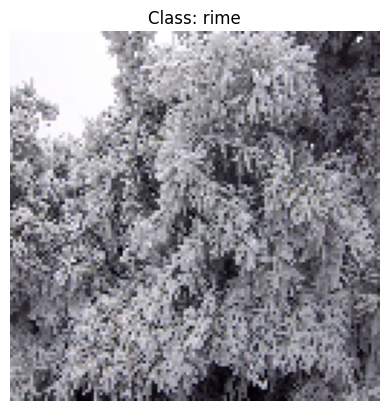

In [9]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Define image size
IMG_SIZE = 128

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)  # Get category names
    class_mapping = {cls: idx for idx, cls in enumerate(class_names)}  # Label mapping

    for cls in class_names:
        class_path = os.path.join(folder, cls)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)  # Read image
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    images.append(img)
                    labels.append(class_mapping[cls])  # Store class label

    return np.array(images), np.array(labels), class_mapping

# Load dataset
images, labels, class_mapping = load_images_from_folder(dataset_path)

# Print dataset details
print(f"✅ Loaded {len(images)} images from {len(class_mapping)} classes.")
print("Class mapping:", class_mapping)

# Display a sample image
plt.imshow(images[0])
plt.title(f"Class: {list(class_mapping.keys())[labels[0]]}")
plt.axis("off")
plt.show()


In [10]:
# Normalize images to 0-1 range
images = images / 255.0  # Convert from 0-255 to 0-1

print("✅ Image normalization complete!")


✅ Image normalization complete!


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate images by up to 20 degrees
    width_shift_range=0.2,  # Shift image width by 20%
    height_shift_range=0.2,  # Shift image height by 20%
    horizontal_flip=True,  # Flip images horizontally
    zoom_range=0.2  # Random zoom
)

# Apply augmentation to images
augmented_images = datagen.flow(images, labels, batch_size=32)

print("✅ Data augmentation ready!")


✅ Data augmentation ready!


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Image Size & Batch Size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Apply Data Augmentation & Normalization (Same as before)
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalization
    validation_split=0.2,    # 20% validation split
    rotation_range=30,       # Rotate images randomly by 30 degrees
    width_shift_range=0.2,   # Shift image width by 20%
    height_shift_range=0.2,  # Shift image height by 20%
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Zoom in/out by 20%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformation
)

# Load Training Data (80%)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'       # 80% for training
)

# Load Validation Data (20%)
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'     # 20% for validation
)

print("✅ Dataset successfully split into 80% training and 20% validation with augmentation!")



Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.
✅ Dataset successfully split into 80% training and 20% validation with augmentation!


In [13]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output Layer
])

print("✅ CNN Model Created Successfully!")


✅ CNN Model Created Successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("✅ Model Compiled Successfully!")


✅ Model Compiled Successfully!


In [15]:
history = model.fit(
    train_generator,
    epochs=10,  # You can increase this if needed
    validation_data=val_generator
)

print("✅ Model Training Complete!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.3618 - loss: 1.8441 - val_accuracy: 0.5917 - val_loss: 1.2437
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.5876 - loss: 1.2161 - val_accuracy: 0.5771 - val_loss: 1.2027
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.5963 - loss: 1.1353 - val_accuracy: 0.6596 - val_loss: 1.0575
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.6511 - loss: 1.0274 - val_accuracy: 0.6435 - val_loss: 1.0486
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6444 - loss: 1.0035 - val_accuracy: 0.6267 - val_loss: 1.0573
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.6530 - loss: 0.9970 - val_accuracy: 0.6472 - val_loss: 1.0415
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.6777 - loss: 0.9650 - val_accuracy: 0.6852 - val_loss: 0.9927
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.6856 - loss: 0.9150 - val_accu

In [16]:
# Evaluate model on validation set
test_loss, test_accuracy = model.evaluate(val_generator)

print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 622ms/step - accuracy: 0.6692 - loss: 0.9472
✅ Test Accuracy: 68.01%
✅ Test Loss: 0.9430
